In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, 
                     p_affine=1., p_lighting=1.)

In [6]:
doc(get_transforms)

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [8]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
data = get_data(224, bs, 'zeros')

In [10]:
data.train_ds[20:30].y

CategoryList (10 items)
pug,great_pyrenees,Sphynx,great_pyrenees,Birman
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images

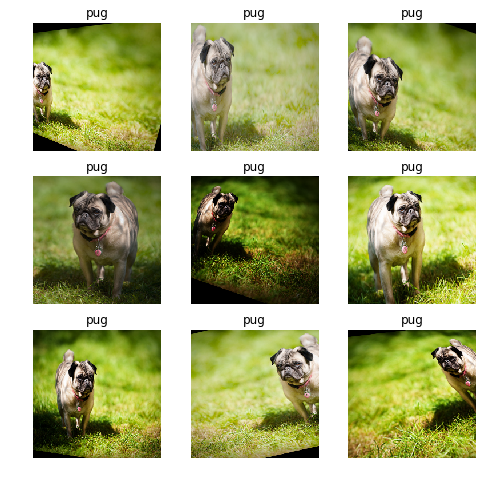

In [11]:
def _plot(i, j, ax):
    x, y = data.train_ds[20]
    x.show(ax, y=y)
#     print(ax) # AxesSubplot(0.125,0.657941;0.227941x0.222059)
    
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [12]:
data = get_data(224, bs)

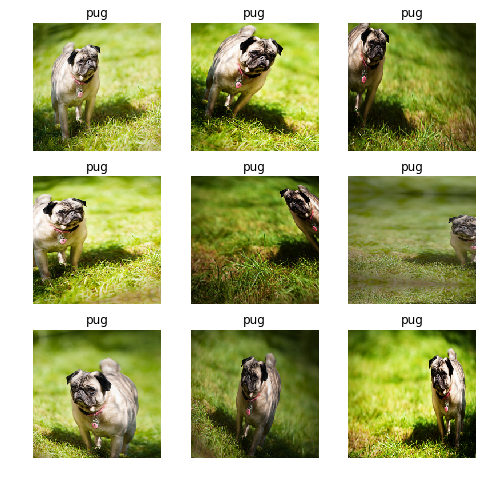

In [13]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

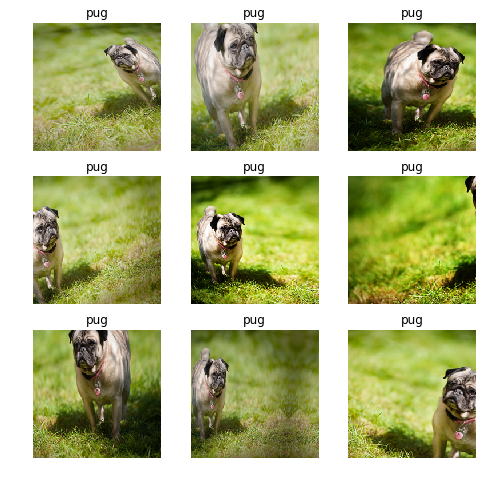

In [14]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [15]:
gc.collect()

43709

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [17]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.466016,1.206347,0.233424,00:29
1,1.459497,0.343593,0.086604,00:27
2,0.895998,0.292112,0.076455,00:26


In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.682625,0.316586,0.070365,00:28
1,0.624676,0.300105,0.068336,00:27


In [20]:
data = get_data(352, bs)
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.595732,0.287978,0.061570,00:50
1,0.595359,0.288161,0.056834,00:50


In [22]:
learn.save('352')

## Convolution Kernel

In [70]:
data = get_data(352, 16)

In [71]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category german_shorthaired

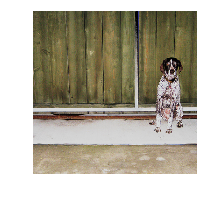

In [72]:
idx = 60
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [73]:
k = tensor([
    [0., -5/3, 1], 
    [-5/3, -5/3, 1], 
    [1., 1, 1],     
]).expand(1, 3, 3, 3)/6

In [74]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [75]:
k.shape

torch.Size([1, 3, 3, 3])

In [81]:
#t = data.valid_ds[0][0].data; 
t = x.data; 

In [82]:
t.shape

torch.Size([3, 352, 352])

In [83]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [84]:
edge = F.conv2d(t[None], k)

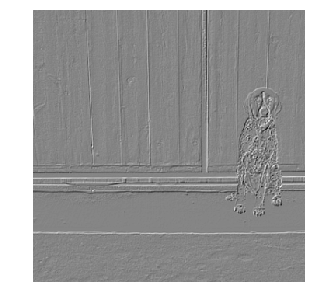

In [85]:
show_image(edge[0], figsize=(5, 5));

In [86]:
data.c

37

In [87]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [88]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

In [89]:
m = learn.model.eval();

In [90]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [91]:
from fastai.callbacks.hooks import *

In [92]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [93]:
hook_a, hook_g = hooked_backward()

In [94]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [95]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [96]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 352, 352, 0), 
             interpolation='bilinear', cmap='magma');

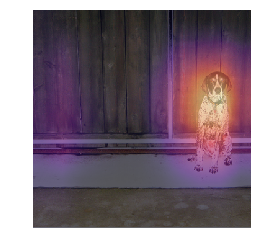

In [97]:
show_heatmap(avg_acts)

## Grad-CAM

In [98]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [99]:
mult = (acts*grad_chan[..., None, None]).mean(0)

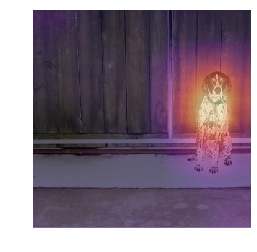

In [100]:
show_heatmap(mult)

In [101]:
# replace with your image
fn = path/'../other/bulldog_maine.jpg' 

In [102]:
x = open_image(fn); x

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/.fastai/data/oxford-iiit-pet/other/bulldog_maine.jpg'

In [103]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [104]:
hook_a, hook_g = hooked_backward()

In [105]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[..., None, None]).mean(0)

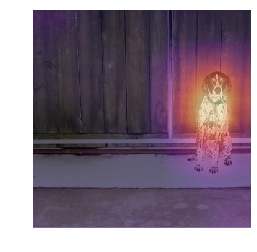

In [106]:
show_heatmap(mult)

In [107]:
data.classes[0]

'Abyssinian'

In [108]:
hook_a, hook_g = hooked_backward(0)

In [109]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[..., None, None]).mean(0)

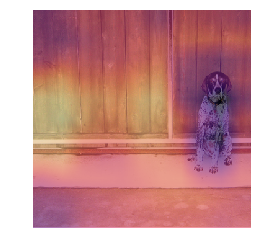

In [110]:
show_heatmap(mult)